# Motor Predictive Maintenance - Real-Time Data Analysis

## Data Collection Format
- **Column 1**: Accelerometer X (g)
- **Column 2**: Accelerometer Y (g)
- **Column 3**: Accelerometer Z (g)
- **Column 4**: Microphone (raw amplitude)
- **Column 5**: Temperature (°C)

Each row represents one sensor reading snapshot.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.fft import fft, fftfreq

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

print('✓ Libraries loaded successfully')

✓ Libraries loaded successfully


## 1. Load Data

In [2]:
# Load data without header
df = pd.read_csv('prediction.csv', header=None, names=['ax_g', 'ay_g', 'az_g', 'mic_raw', 'temp_C'])

# Add reading number as index
df['reading_num'] = range(1, len(df) + 1)

print(f"📊 Data Summary")
print("=" * 60)
print(f"Total readings: {len(df)}")
print(f"Columns: {list(df.columns)}")
print("=" * 60)

# Display first and last few rows
display(df.head(10))
print("\n...\n")
display(df.tail(5))

📊 Data Summary
Total readings: 126
Columns: ['ax_g', 'ay_g', 'az_g', 'mic_raw', 'temp_C', 'reading_num']


,ax_g,ay_g,az_g,mic_raw,temp_C,reading_num
0,-0.07,0.55,0.84,41036,25.01,1
1,-0.07,0.54,0.85,42004,24.97,2
2,-0.06,0.55,0.85,22548,25.01,3
3,-0.06,0.55,0.85,20030,24.97,4
4,-0.06,0.55,0.85,36974,25.11,5
5,-0.06,0.56,0.84,18142,25.11,6
6,-0.07,0.55,0.83,22624,25.19,7
7,-0.07,0.55,0.86,20032,25.19,8
8,-0.06,0.55,0.85,20508,25.09,9
9,-0.07,0.55,0.85,26800,24.91,10



...



,ax_g,ay_g,az_g,mic_raw,temp_C,reading_num
121,-0.20,0.14,0.94,99146,24.07,122
122,-0.20,0.15,0.98,61048,24.49,123
123,-0.20,0.15,0.98,54222,24.57,124
124,-0.21,0.15,0.98,49726,24.59,125
125,-0.20,0.16,0.98,30960,24.53,126


## 2. Data Quality & Statistics

In [3]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())
print("\n" + "="*60 + "\n")

# Statistical summary
print("Statistical Summary:")
df.describe()

Missing Values:
ax_g           0
ay_g           0
az_g           0
mic_raw        0
temp_C         0
reading_num    0
dtype: int64


Statistical Summary:


,ax_g,ay_g,az_g,mic_raw,temp_C,reading_num
count,126.000000,126.000000,126.000000,1.260000e+02,126.000000,126.000000
mean,-0.072222,0.411111,0.865952,1.225071e+05,26.994286,63.500000
std,0.141652,0.254540,0.287837,5.774671e+05,2.746309,36.517119
min,-1.010000,-0.660000,-1.260000,1.733000e+04,24.070000,1.000000
25%,-0.135000,0.190000,0.850000,2.483750e+04,24.955000,32.250000
50%,-0.040000,0.510000,0.870000,4.494900e+04,25.280000,63.500000
75%,-0.022500,0.540000,0.957500,8.644400e+04,28.730000,94.750000
max,0.430000,1.440000,2.040000,6.496218e+06,33.830000,126.000000


In [4]:
# Identify outliers/anomalies
print("🚨 Potential Anomalies (based on extreme values):\n")

# Accelerometer outliers (>1.5g is unusual)
accel_threshold = 1.0
accel_outliers = df[(np.abs(df['ax_g']) > accel_threshold) | 
                     (np.abs(df['ay_g']) > accel_threshold) | 
                     (np.abs(df['az_g']) > accel_threshold)]

if len(accel_outliers) > 0:
    print(f"⚠️  High Vibration Readings ({len(accel_outliers)} occurrences):")
    display(accel_outliers[['reading_num', 'ax_g', 'ay_g', 'az_g', 'temp_C']])
    
# Microphone outliers (using IQR method)
Q1 = df['mic_raw'].quantile(0.25)
Q3 = df['mic_raw'].quantile(0.75)
IQR = Q3 - Q1
mic_outliers = df[df['mic_raw'] > Q3 + 1.5 * IQR]

if len(mic_outliers) > 0:
    print(f"\n⚠️  Unusual Microphone Readings ({len(mic_outliers)} occurrences):")
    display(mic_outliers[['reading_num', 'mic_raw', 'temp_C', 'ax_g', 'ay_g', 'az_g']].sort_values('mic_raw', ascending=False))

# Temperature extremes
temp_high = df[df['temp_C'] > 32]
if len(temp_high) > 0:
    print(f"\n🌡️  High Temperature Readings (>32°C): {len(temp_high)} occurrences")
    print(f"   Max temp: {df['temp_C'].max():.2f}°C at reading #{df[df['temp_C'] == df['temp_C'].max()]['reading_num'].values[0]}")

🚨 Potential Anomalies (based on extreme values):

⚠️  High Vibration Readings (9 occurrences):


,reading_num,ax_g,ay_g,az_g,temp_C
11,12,0.24,-0.54,-1.26,25.19
14,15,-0.10,1.44,-0.06,25.33
39,40,-0.17,0.30,1.20,28.85
65,66,0.03,0.64,1.04,28.61
91,92,-0.12,0.24,1.14,25.45
92,93,0.42,-0.33,1.92,25.17
93,94,-0.44,0.40,2.04,24.93
94,95,-1.01,1.21,0.28,24.97
96,97,-0.14,0.01,1.21,24.77



⚠️  Unusual Microphone Readings (12 occurrences):


,reading_num,mic_raw,temp_C,ax_g,ay_g,az_g
96,97,6496218,24.77,-0.14,0.01,1.21
11,12,591314,25.19,0.24,-0.54,-1.26
65,66,358670,28.61,0.03,0.64,1.04
113,114,243662,24.69,-0.21,0.19,0.97
108,109,239538,24.75,-0.21,0.18,0.96
67,68,225578,27.81,-0.02,0.51,0.86
116,117,223820,24.75,-0.21,0.19,0.97
83,84,220140,25.25,-0.03,0.52,0.87
115,116,198176,24.61,-0.20,0.18,0.97
110,111,195878,24.87,-0.20,0.19,0.97



🌡️  High Temperature Readings (>32°C): 11 occurrences
   Max temp: 33.83°C at reading #54


## 3. Time Series Visualization

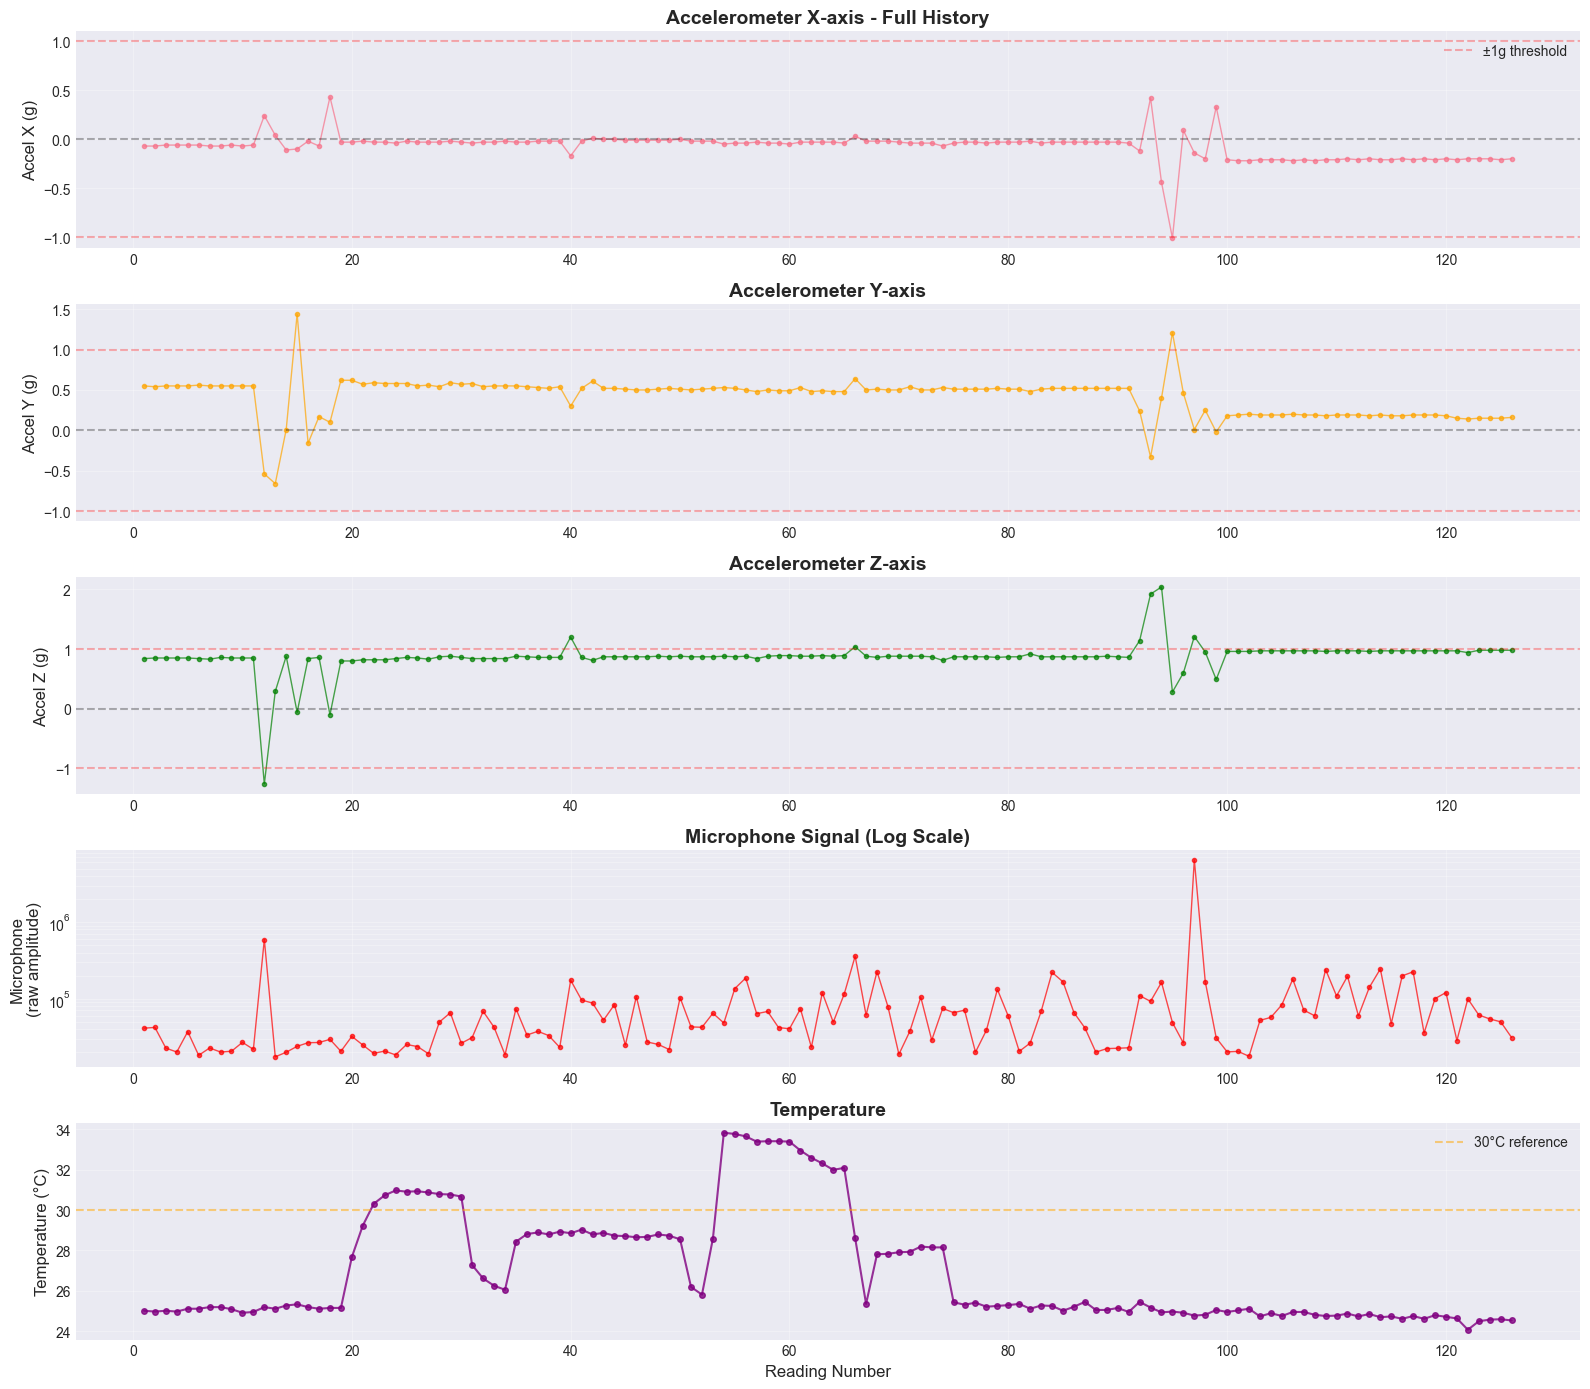

In [5]:
# Plot all sensors over time
fig, axes = plt.subplots(5, 1, figsize=(16, 14))

# Accelerometer X
axes[0].plot(df['reading_num'], df['ax_g'], marker='o', markersize=3, linewidth=1, alpha=0.7)
axes[0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[0].axhline(y=1, color='r', linestyle='--', alpha=0.3, label='±1g threshold')
axes[0].axhline(y=-1, color='r', linestyle='--', alpha=0.3)
axes[0].set_ylabel('Accel X (g)', fontsize=12)
axes[0].set_title('Accelerometer X-axis - Full History', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accelerometer Y
axes[1].plot(df['reading_num'], df['ay_g'], marker='o', markersize=3, linewidth=1, alpha=0.7, color='orange')
axes[1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[1].axhline(y=1, color='r', linestyle='--', alpha=0.3)
axes[1].axhline(y=-1, color='r', linestyle='--', alpha=0.3)
axes[1].set_ylabel('Accel Y (g)', fontsize=12)
axes[1].set_title('Accelerometer Y-axis', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Accelerometer Z
axes[2].plot(df['reading_num'], df['az_g'], marker='o', markersize=3, linewidth=1, alpha=0.7, color='green')
axes[2].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[2].axhline(y=1, color='r', linestyle='--', alpha=0.3)
axes[2].axhline(y=-1, color='r', linestyle='--', alpha=0.3)
axes[2].set_ylabel('Accel Z (g)', fontsize=12)
axes[2].set_title('Accelerometer Z-axis', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

# Microphone (log scale due to huge range)
axes[3].plot(df['reading_num'], df['mic_raw'], marker='o', markersize=3, linewidth=1, alpha=0.7, color='red')
axes[3].set_ylabel('Microphone\n(raw amplitude)', fontsize=12)
axes[3].set_yscale('log')  # Log scale to see patterns
axes[3].set_title('Microphone Signal (Log Scale)', fontsize=14, fontweight='bold')
axes[3].grid(True, alpha=0.3, which='both')

# Temperature
axes[4].plot(df['reading_num'], df['temp_C'], marker='o', markersize=4, linewidth=1.5, alpha=0.8, color='purple')
axes[4].axhline(y=30, color='orange', linestyle='--', alpha=0.5, label='30°C reference')
axes[4].set_ylabel('Temperature (°C)', fontsize=12)
axes[4].set_xlabel('Reading Number', fontsize=12)
axes[4].set_title('Temperature', fontsize=14, fontweight='bold')
axes[4].legend()
axes[4].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Vibration Magnitude Analysis

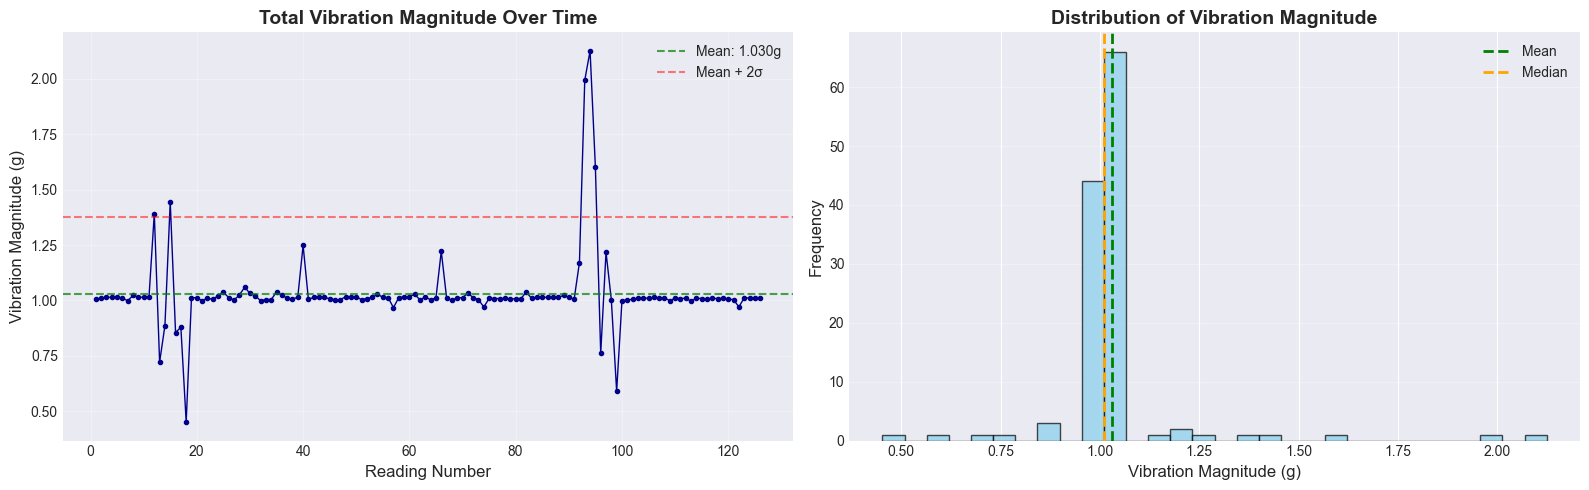

Vibration Statistics:
  Mean: 1.0300g
  Std:  0.1724g
  Max:  2.1249g (reading #94)


In [6]:
# Calculate overall vibration magnitude
df['vibration_magnitude'] = np.sqrt(df['ax_g']**2 + df['ay_g']**2 + df['az_g']**2)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Vibration magnitude over time
axes[0].plot(df['reading_num'], df['vibration_magnitude'], marker='o', markersize=3, linewidth=1, color='darkblue')
axes[0].axhline(y=df['vibration_magnitude'].mean(), color='green', linestyle='--', 
                alpha=0.7, label=f"Mean: {df['vibration_magnitude'].mean():.3f}g")
axes[0].axhline(y=df['vibration_magnitude'].mean() + 2*df['vibration_magnitude'].std(), 
                color='red', linestyle='--', alpha=0.5, label='Mean + 2σ')
axes[0].set_xlabel('Reading Number', fontsize=12)
axes[0].set_ylabel('Vibration Magnitude (g)', fontsize=12)
axes[0].set_title('Total Vibration Magnitude Over Time', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Distribution of vibration magnitude
axes[1].hist(df['vibration_magnitude'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[1].axvline(x=df['vibration_magnitude'].mean(), color='green', linestyle='--', linewidth=2, label='Mean')
axes[1].axvline(x=df['vibration_magnitude'].median(), color='orange', linestyle='--', linewidth=2, label='Median')
axes[1].set_xlabel('Vibration Magnitude (g)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Vibration Magnitude', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"Vibration Statistics:")
print(f"  Mean: {df['vibration_magnitude'].mean():.4f}g")
print(f"  Std:  {df['vibration_magnitude'].std():.4f}g")
print(f"  Max:  {df['vibration_magnitude'].max():.4f}g (reading #{df['vibration_magnitude'].idxmax() + 1})")

## 5. Correlation Analysis

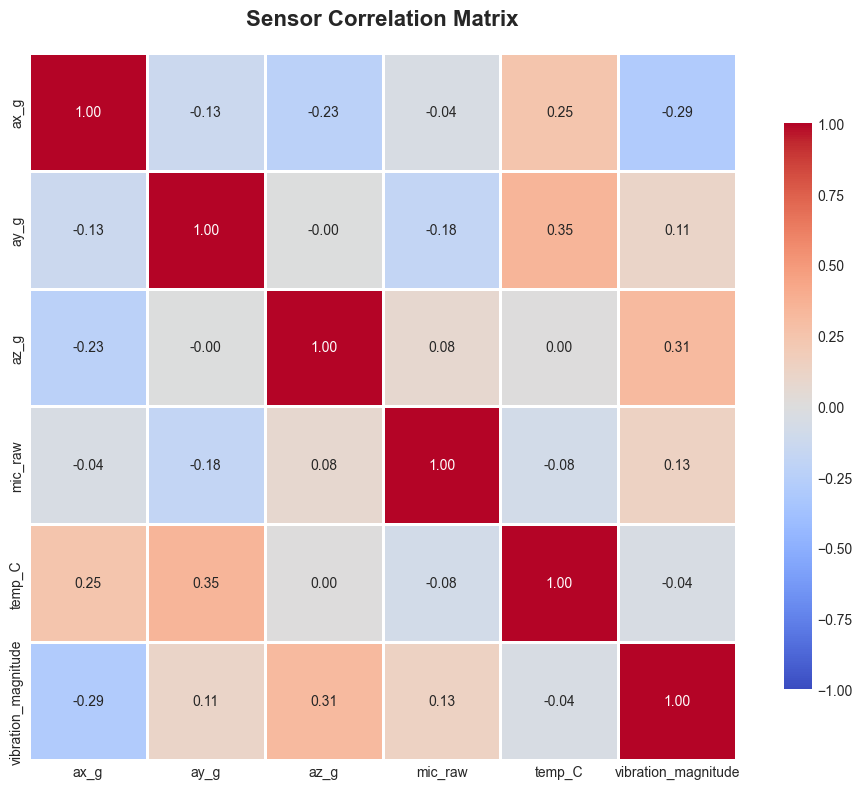


🔍 Key Correlations:
  Temperature vs Vibration Magnitude: -0.039
  Temperature vs Microphone: -0.079


In [7]:
# Create correlation matrix
corr_cols = ['ax_g', 'ay_g', 'az_g', 'mic_raw', 'temp_C', 'vibration_magnitude']
corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=2, cbar_kws={"shrink": 0.8}, fmt='.2f',
            vmin=-1, vmax=1)
plt.title('Sensor Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n🔍 Key Correlations:")
print(f"  Temperature vs Vibration Magnitude: {df['temp_C'].corr(df['vibration_magnitude']):.3f}")
print(f"  Temperature vs Microphone: {df['temp_C'].corr(df['mic_raw']):.3f}")

## 6. Scatter Plots - Relationship Analysis

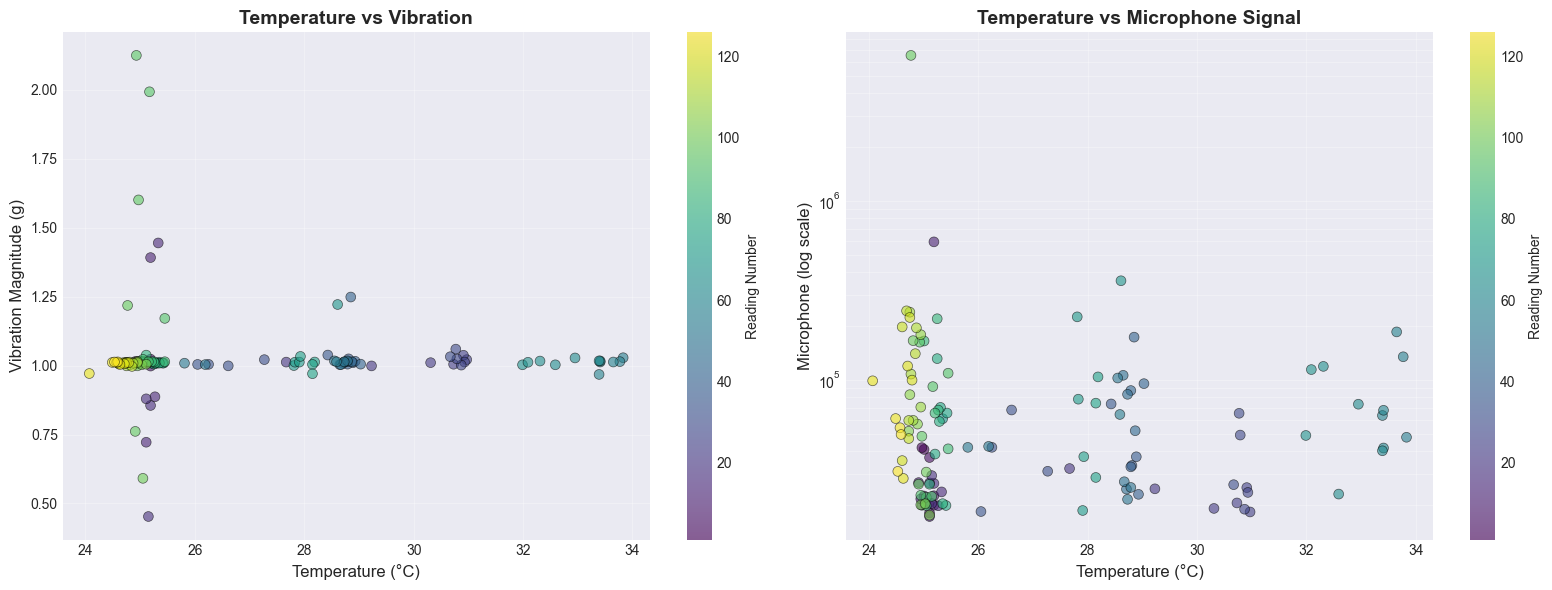

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Temperature vs Vibration
scatter1 = axes[0].scatter(df['temp_C'], df['vibration_magnitude'], 
                           c=df['reading_num'], cmap='viridis', 
                           s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('Temperature (°C)', fontsize=12)
axes[0].set_ylabel('Vibration Magnitude (g)', fontsize=12)
axes[0].set_title('Temperature vs Vibration', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Reading Number')

# Temperature vs Microphone (log scale)
scatter2 = axes[1].scatter(df['temp_C'], df['mic_raw'], 
                           c=df['reading_num'], cmap='viridis', 
                           s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('Temperature (°C)', fontsize=12)
axes[1].set_ylabel('Microphone (log scale)', fontsize=12)
axes[1].set_yscale('log')
axes[1].set_title('Temperature vs Microphone Signal', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, which='both')
plt.colorbar(scatter2, ax=axes[1], label='Reading Number')

plt.tight_layout()
plt.show()

## 7. 3D Accelerometer Visualization

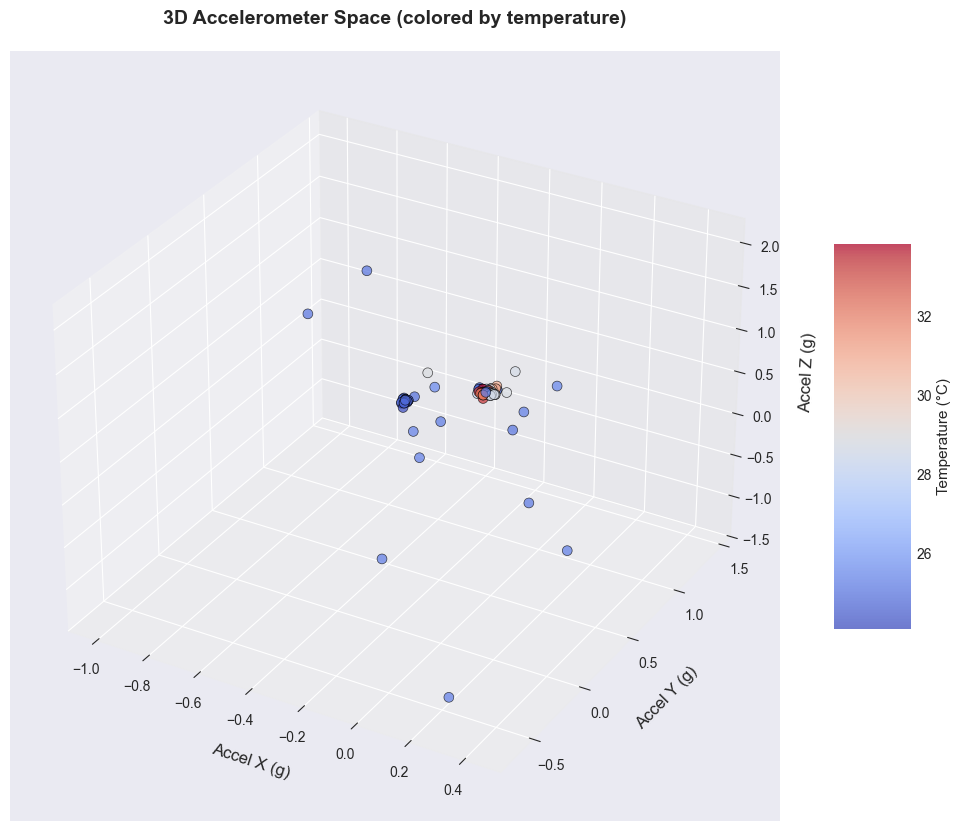

In [9]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df['ax_g'], df['ay_g'], df['az_g'], 
                     c=df['temp_C'], cmap='coolwarm', 
                     s=50, alpha=0.7, edgecolors='black', linewidth=0.5)

ax.set_xlabel('Accel X (g)', fontsize=12, labelpad=10)
ax.set_ylabel('Accel Y (g)', fontsize=12, labelpad=10)
ax.set_zlabel('Accel Z (g)', fontsize=12, labelpad=10)
ax.set_title('3D Accelerometer Space (colored by temperature)', fontsize=14, fontweight='bold', pad=20)

cbar = plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Temperature (°C)', fontsize=11)

plt.show()

## 8. Rolling Statistics (Trends)

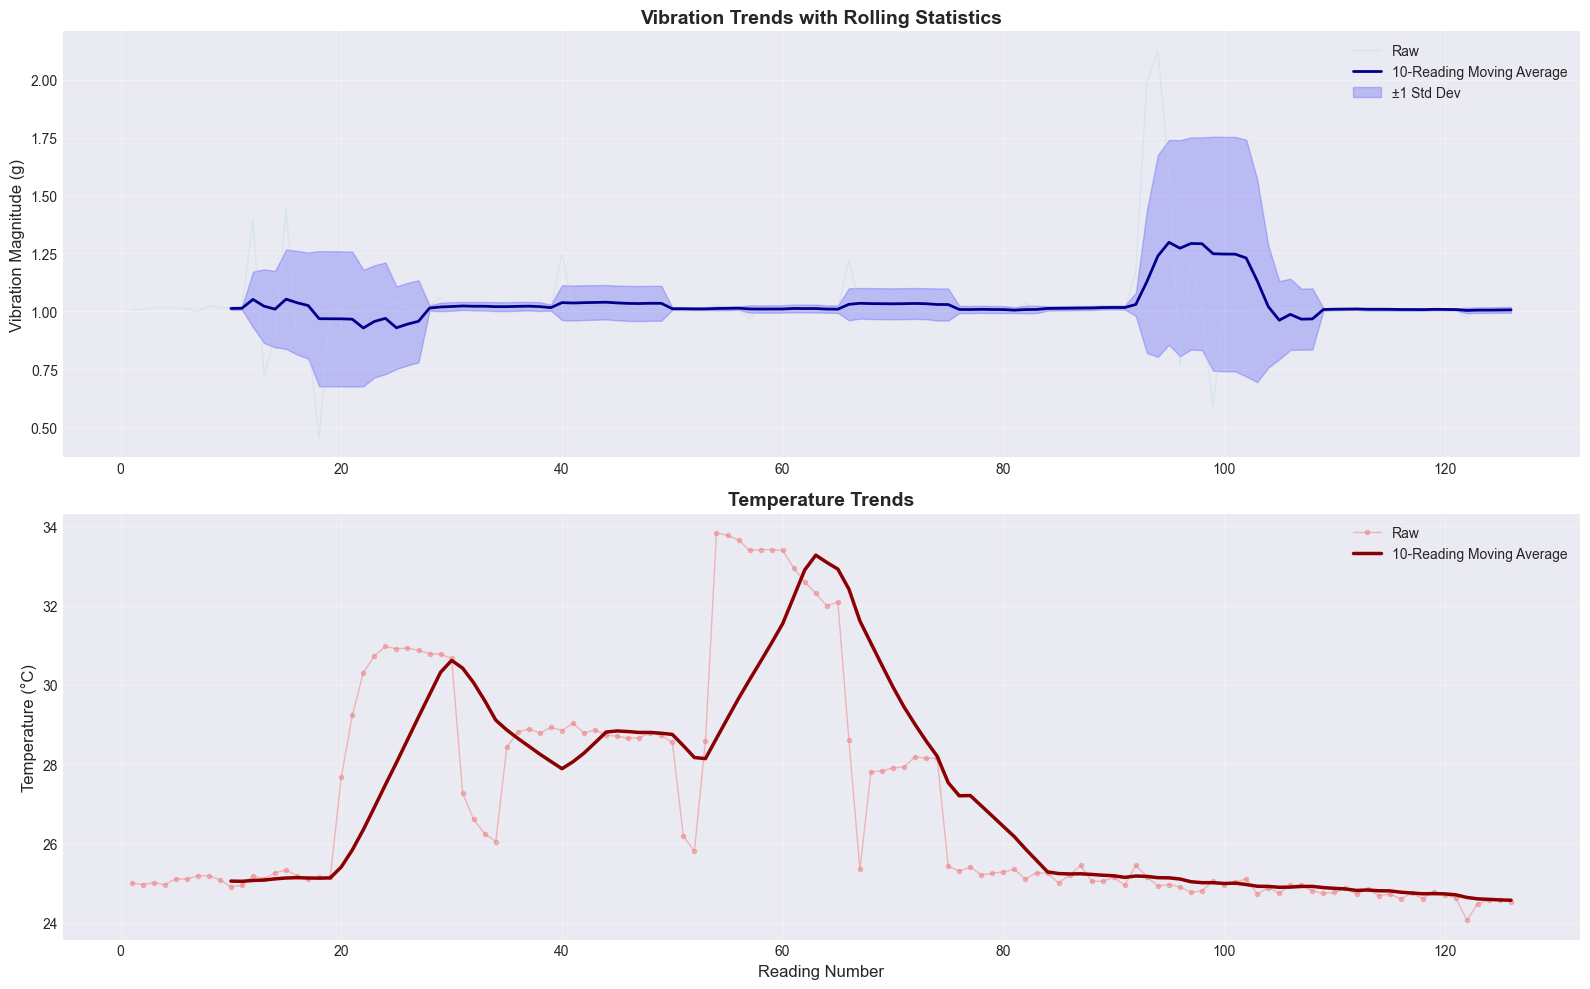

In [10]:
# Calculate rolling statistics
window = 10  # 10-reading window

df['vibration_rolling_mean'] = df['vibration_magnitude'].rolling(window=window).mean()
df['vibration_rolling_std'] = df['vibration_magnitude'].rolling(window=window).std()
df['temp_rolling_mean'] = df['temp_C'].rolling(window=window).mean()

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Vibration trends
axes[0].plot(df['reading_num'], df['vibration_magnitude'], 
             alpha=0.3, linewidth=1, label='Raw', color='lightblue')
axes[0].plot(df['reading_num'], df['vibration_rolling_mean'], 
             linewidth=2, label=f'{window}-Reading Moving Average', color='darkblue')
axes[0].fill_between(df['reading_num'], 
                      df['vibration_rolling_mean'] - df['vibration_rolling_std'],
                      df['vibration_rolling_mean'] + df['vibration_rolling_std'],
                      alpha=0.2, color='blue', label='±1 Std Dev')
axes[0].set_ylabel('Vibration Magnitude (g)', fontsize=12)
axes[0].set_title('Vibration Trends with Rolling Statistics', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Temperature trends
axes[1].plot(df['reading_num'], df['temp_C'], 
             alpha=0.5, linewidth=1, marker='o', markersize=3, label='Raw', color='lightcoral')
axes[1].plot(df['reading_num'], df['temp_rolling_mean'], 
             linewidth=2.5, label=f'{window}-Reading Moving Average', color='darkred')
axes[1].set_xlabel('Reading Number', fontsize=12)
axes[1].set_ylabel('Temperature (°C)', fontsize=12)
axes[1].set_title('Temperature Trends', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Summary Report

In [11]:
print("="*70)
print(" MOTOR HEALTH SUMMARY REPORT")
print("="*70)

print(f"\n📊 Dataset Overview:")
print(f"   Total Readings: {len(df)}")
print(f"   Data Collection: Ongoing (real-time)")

print(f"\n🔧 Vibration Analysis:")
print(f"   Mean Magnitude: {df['vibration_magnitude'].mean():.4f}g")
print(f"   Std Deviation: {df['vibration_magnitude'].std():.4f}g")
print(f"   Max Observed: {df['vibration_magnitude'].max():.4f}g")
high_vib = len(df[df['vibration_magnitude'] > 1.5])
print(f"   High Vibration Events (>1.5g): {high_vib} ({high_vib/len(df)*100:.1f}%)")

print(f"\n🌡️  Temperature Analysis:")
print(f"   Current: {df['temp_C'].iloc[-1]:.2f}°C")
print(f"   Mean: {df['temp_C'].mean():.2f}°C")
print(f"   Range: {df['temp_C'].min():.2f}°C - {df['temp_C'].max():.2f}°C")
print(f"   Trend: {'↑ Rising' if df['temp_C'].iloc[-10:].mean() > df['temp_C'].iloc[:10].mean() else '↓ Falling'}")

print(f"\n🎤 Microphone Analysis:")
print(f"   Median: {df['mic_raw'].median():.0f}")
print(f"   Max Peak: {df['mic_raw'].max():.0f}")
print(f"   Outliers Detected: {len(mic_outliers)}")

print(f"\n⚠️  Anomaly Detection:")
if len(accel_outliers) > 0:
    print(f"   🔴 {len(accel_outliers)} High Vibration Anomalies Detected")
else:
    print(f"   ✅ No High Vibration Anomalies")

if df['temp_C'].max() > 32:
    print(f"   🟡 Temperature exceeded 32°C ({df['temp_C'].max():.1f}°C max)")
else:
    print(f"   ✅ Temperature within normal range")

print(f"\n💡 Recommendations:")
if high_vib > 5:
    print("   - Monitor motor for unusual vibrations")
    print("   - Check mounting and alignment")
if df['temp_C'].max() > 32:
    print("   - Monitor temperature trends closely")
    print("   - Ensure adequate cooling")
if len(df) < 100:
    print("   - Continue collecting baseline data")
    print("   - Need more readings to establish normal patterns")
else:
    print("   - Sufficient data for initial baseline analysis")
    print("   - Ready for anomaly detection model training")

print("\n" + "="*70)

 MOTOR HEALTH SUMMARY REPORT

📊 Dataset Overview:
   Total Readings: 126
   Data Collection: Ongoing (real-time)

🔧 Vibration Analysis:
   Mean Magnitude: 1.0300g
   Std Deviation: 0.1724g
   Max Observed: 2.1249g
   High Vibration Events (>1.5g): 3 (2.4%)

🌡️  Temperature Analysis:
   Current: 24.53°C
   Mean: 26.99°C
   Range: 24.07°C - 33.83°C
   Trend: ↓ Falling

🎤 Microphone Analysis:
   Median: 44949
   Max Peak: 6496218
   Outliers Detected: 12

⚠️  Anomaly Detection:
   🔴 9 High Vibration Anomalies Detected
   🟡 Temperature exceeded 32°C (33.8°C max)

💡 Recommendations:
   - Monitor temperature trends closely
   - Ensure adequate cooling
   - Sufficient data for initial baseline analysis
   - Ready for anomaly detection model training



## 10. Export Processed Data

In [12]:
# Save processed data with calculated features
df.to_csv('motor_data_processed.csv', index=False)
print('✓ Processed data saved to: motor_data_processed.csv')

# Save summary statistics
summary = df[['ax_g', 'ay_g', 'az_g', 'mic_raw', 'temp_C', 'vibration_magnitude']].describe()
summary.to_csv('motor_data_summary.csv')
print('✓ Summary statistics saved to: motor_data_summary.csv')

✓ Processed data saved to: motor_data_processed.csv
✓ Summary statistics saved to: motor_data_summary.csv


---

## Next Steps:

1. **Continue Data Collection**: Keep adding readings to build a comprehensive baseline
2. **Label Data**: Mark readings during known motor states (normal, high load, etc.)
3. **Feature Engineering**: Create more sophisticated features from raw signals
4. **Anomaly Detection**: Once baseline established, train unsupervised models
5. **Real-time Monitoring**: Set up alerts for unusual patterns